In [1]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
plt.style.use('seaborn')

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
# Load data
df = pd.read_csv('../input/PJME_hourly.csv',index_col=['Datetime'],parse_dates=['Datetime'])
print('Number of samples :', df.shape[0])

Number of samples : 145366


In [3]:
df.head(4)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0


In [4]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


## Check for missing value

In [5]:
df.isna().sum()

PJME_MW    0
dtype: int64

## Split data 

In [6]:
date_index = '01-Jan-2014'
df_train = df.loc[df.index<date_index]
df_test = df.loc[df.index>date_index]
print('Number of train samples:', df_train.shape[0],
      '\n Number of test samples:', df_test.shape[0])


Number of train samples: 105166 
 Number of test samples: 40199


## Data vizualisation

In [7]:
def plot_data(df1,df2):
    plt.figure(figsize=(12,5))
    plt.title('PJME_MW')
    plt.plot(df1)
    plt.plot(df2)
    plt.legend(['Train','Test'])
    plt.show()

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


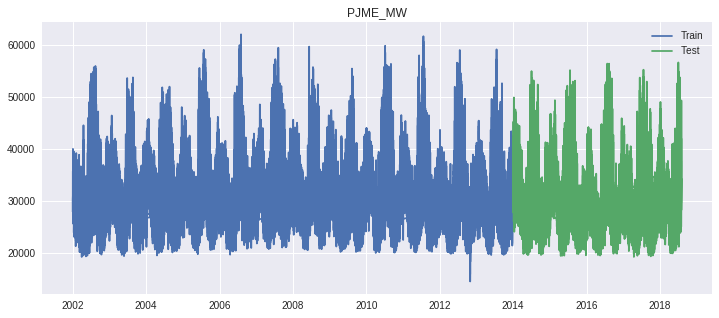

In [8]:
plot_data(df_train,df_test)

## Data preprocessing

In [9]:
# Standardize data by removing the mean and scaling to unit variance
scaler = StandardScaler()
df_train['PJME_MW'] = scaler.fit_transform(df_train['PJME_MW'].values.reshape(-1,1))
df_test['PJME_MW'] = scaler.fit_transform(df_test['PJME_MW'].values.reshape(-1,1)) 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [10]:
def process_data(sequence,data):
    """ Process data to have the necessary input shape
        N_samples,sequence length,N_features"""
    
    X = []
    y = []
    
    for i in range(sequence, data.shape[0]):
        
        X.append(data.iloc[i-sequence:i,0])
        y.append(data.iloc[i,0])
        
    X = np.array(X)
    y = np.array(y)
    
    # Reshape data as (N_samples,sequence length,N_features)
    X = np.reshape(X,(X.shape[0],sequence,1))
    
    return X,y

In [11]:
X_train, y_train = process_data(30, df_train)
X_test , y_test = process_data(30, df_test)

## Create LSTM model


In [12]:
model = Sequential()

model.add(LSTM(60,activation='tanh',return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(60,activation='tanh',return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(60,activation='tanh',return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))

In [13]:
model.compile(loss='MSE', optimizer='adam')

In [14]:
history = model.fit(X_train,y_train, epochs=10,batch_size=1000)

Epoch 1/10
105136/105136 [==============================] - 24s 225us/step - loss: 0.3347
Epoch 2/10
105136/105136 [==============================] - 18s 167us/step - loss: 0.1216
Epoch 3/10
105136/105136 [==============================] - 19s 176us/step - loss: 0.0868
Epoch 4/10
105136/105136 [==============================] - 18s 168us/step - loss: 0.0649
Epoch 5/10
105136/105136 [==============================] - 18s 167us/step - loss: 0.0535
Epoch 6/10
105136/105136 [==============================] - 18s 167us/step - loss: 0.0457
Epoch 7/10
105136/105136 [==============================] - 18s 167us/step - loss: 0.0404
Epoch 8/10
105136/105136 [==============================] - 18s 168us/step - loss: 0.0362
Epoch 9/10
105136/105136 [==============================] - 17s 166us/step - loss: 0.0332
Epoch 10/10
105136/105136 [==============================] - 17s 165us/step - loss: 0.0305


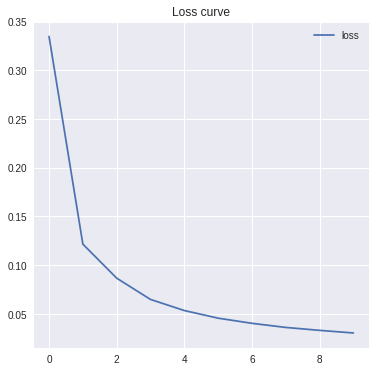

In [15]:
plt.figure(figsize=(6,6))
plt.title('Loss curve')
plt.plot(history.history['loss'])
plt.legend(['loss'],loc='best')

In [16]:
# Make predictions using trained model
y_pred = model.predict(X_test)

In [17]:
# Scale back data to the original representation
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred)

In [18]:
def evaluate_model(pred,true):
    
    score = r2_score(true, pred)
    RMSE = np.sqrt(mean_squared_error(true,pred))
    MAE = mean_absolute_error(true,pred)
    #MAPE = np.mean(np.abs((true - pred) / true)) * 100

    print("R2 Score :", score)
    print("RMSE :", RMSE)
    print("Mean absolute error :", MAE)
    #print("Mean absolute percentage error :", MAPE)
    
    return score, RMSE, MAE

In [19]:
evaluate_model(y_pred, y_test)

R2 Score : 0.9814623775803502
RMSE : 868.0101433303395
Mean absolute error : 589.3538847684937


(0.9814623775803502, 868.0101433303395, 589.3538847684937)

# Compare prediction vs ground truth

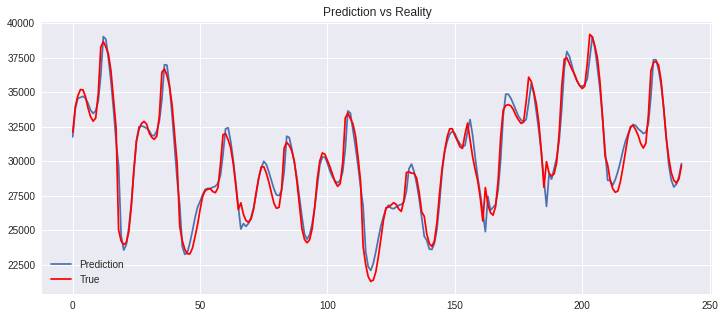

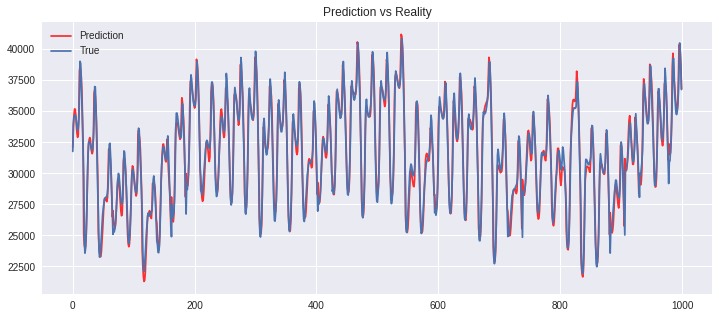

In [20]:
plt.figure(figsize=(12,5))
plt.title('Prediction vs Reality')
plt.plot(y_pred[:10*24])
plt.plot(y_test[:10*24],color='red')
plt.legend(['Prediction','True'],loc='best')
plt.show()

plt.figure(figsize=(12,5))
plt.title('Prediction vs Reality')
plt.plot(y_test[:1000],color='red',linestyle='-',alpha=0.8)
plt.plot(y_pred[:1000])
plt.legend(['Prediction','True'],loc='best')
plt.show()

In [21]:
# batchs_size = [240,480,980,1960]

# r2_sc = []
# RMSE = []
# MAE = []
# MAPE = []

# for batch in batchs_size :
    
#     history = model.fit(X_train,y_train,epochs=10,batch_size=batch)
#     y_pred = model.predict(X_test)
#     y_pred = scaler.inverse_transform(y_pred)    
#     r2, rmse, mae , mape = evaluate_model(y_pred,y_test)
    
#     RMSE.append(rmse)
#     r2_sc.append(r2)
#     MAE.append(mae)
#     MAPE.append(mape)

In [22]:
# index = ['r2_score','rmse','mae','mape']
# df = pd.DataFrame({'l1':RMSE,'l2':r2_sc,'l3':MAE,'l4':MAPE},index=index)
# # df.plot.bar(rot=0)